### Import modules

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.patches import Ellipse


In [2]:
def getNoise(data):
    tmp = np.copy(data)
    tmp[np.abs(tmp) > 3*np.std(tmp)] = 0
    tmp[np.abs(tmp) > 3*np.std(tmp)] = 0
    return np.std(tmp)

    
def getOffset(freq):
    r = -0.01 + 161.37*freq**(-1.16)
    return r
    
    

def getX(utc, f):
    """
    input utc and f for which we need X
    """
    ## values from vla
    refTime = datetime.strptime('2010-01-1', '%Y-%m-%d') ## arbitarry ref
    
    utc1 = (datetime.strptime('2012-05-27', '%Y-%m-%d') - refTime).total_seconds()/(3600*24)
    utc2 = (datetime.strptime('2014-01-13', '%Y-%m-%d') - refTime).total_seconds()/(3600*24)
        
    c = 3e8  # Speed of light in m/s
    f1 = 5
    f2 = 8.4
    
    ## values from nrao page
    X1_f1 = -60.635
    X1_f2 = 2.040	

    ## values obtained by me by reducing vla obs
    X2_f1 = -62.63
    X2_f2 = -2.19

    ## interpolate in time (Step 1)
    utc_float = (utc - refTime).total_seconds()/(3600*24)
    fn_band1 = np.poly1d(np.polyfit([utc1, utc2], [X1_f1, X2_f1], 1))
    fn_band2 = np.poly1d(np.polyfit([utc1, utc2], [X1_f2, X2_f2], 1))
    
    X1_for_utc = fn_band1(utc_float)
    X2_for_utc = fn_band2(utc_float)
    
    ### interpolate in lambda squared (Step 2)
    lambda1_squared = (c / (f1*1e9))**2
    lambda2_squared = (c / (f2*1e9))**2
    
    lambda_squared = (c / (f*1e9))**2
    
    fn_lambdaSquared = np.poly1d(np.polyfit([lambda1_squared, lambda2_squared],\
                                            [X1_for_utc, X2_for_utc], 1))
    
    return fn_lambdaSquared(lambda_squared)


def getCorrection(epoch, band):
    hduQ = fits.open('/media/steve/NewSSD/papers/cenAVLBA/oldPolAnalysis/epoch{0}/band{1}/J2202-Q.fits'.format(epoch, band))
    hduU = fits.open('/media/steve/NewSSD/papers/cenAVLBA/oldPolAnalysis/epoch{0}/band{1}/J2202-U.fits'.format(epoch, band))
    utc = datetime.strptime(hduQ[0].header['DATE-OBS'], '%Y-%m-%d')
    dataQ = hduQ[0].data[0,0,:,:]
    dataU = hduU[0].data[0,0,:,:]
    freqQ = hduQ[0].header['CRVAL3']*1e-9
    utcQ = datetime.strptime(hduQ[0].header['DATE-OBS'], '%Y-%m-%d')
    
    lin_pol = np.sqrt(dataQ**2 + dataU**2)
    max_row, max_col = np.where(lin_pol == np.nanmax(lin_pol))
    
    polAngle = np.degrees(1/2*np.arctan2(dataU[max_row, max_col], dataQ[max_row, max_col])) 
    actual_angle = getX(utcQ, freqQ)

    return float(actual_angle - polAngle)



def getData(epoch, band, ax):
    hfont = {'family' : 'normal',
        'size'   : 12}

    hdu = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH12/band11/CENA-Q-8.fits')
    freq0 = float(hdu[0].header['CRVAL3'])/1e9
    try:
        hduI = fits.open('/media/steve/NewSSD/papers/cenAVLBA/oldPolAnalysis/epoch{}/band{}/CenaNaturalI.fits'.format(epoch, band))
    except:
        ax.set_xlim(70, -70)
        ax.set_ylim(-100, 120)
        ax.hlines(0, -150, 150, color='black', linestyle='dashed', alpha=0.5)
        ax.vlines(0, -150, 150, color='black', linestyle='dashed', alpha=0.5)
    
        return np.nan
    hduQ = fits.open('/media/steve/NewSSD/papers/cenAVLBA/oldPolAnalysis/epoch{}/band{}/CenaNaturalQ.fits'.format(epoch, band))
    hduU = fits.open('/media/steve/NewSSD/papers/cenAVLBA/oldPolAnalysis/epoch{}/band{}/CenaNaturalU.fits'.format(epoch, band))
    bmin = hduI[0].header['BMIN']
    bmaj = hduI[0].header['BMAJ']
    bpa = hduI[0].header['BPA']
    bmin = bmin*3600*1e3
    bmaj = bmaj*3600*1e3
    
    elpse = Ellipse(xy=[60, -85], width = bmin, height = bmaj, angle=-bpa, color='black', alpha=0.7, edgecolor='black', zorder=10) 
    ax.add_artist(elpse)
    
    #dataI_tmp = rotate(hduI[0].data[0,0,:,:], 90 - 42, order=5, reshape=False)
    #dataQ_tmp = rotate(hduQ[0].data[0,0,:,:], 90 - 42, order=5, reshape=False)
    #dataU_tmp = rotate(hduU[0].data[0,0,:,:], 90 - 42, order=5, reshape=False)

    #dataI_tmp = hduI[0].data[0,0,:,:]
    #dataQ_tmp = hduQ[0].data[0,0,:,:]
    #dataU_tmp = hduU[0].data[0,0,:,:]
    
    freqQ = float(hduQ[0].header['CRVAL3'])/1e9
    try:
        correction = getCorrection(epoch, band)
        ax.text(65, 110, str(round(freqQ, 3)) + ' GHz', **hfont)
    except:
        ax.text(65, 110, str(round(freqQ, 3)) + ' GHz*', **hfont) 
        
    #core_shift = getOffset(freq0)- getOffset(freqQ) 
    #core_shift_ra = core_shift*np.sin(np.radians(48))
    #core_shift_dec = core_shift*np.cos(np.radians(48))

    #dataI_tmp_1 = np.roll(dataI_tmp, -int(core_shift_ra/0.2), axis=0)
    #dataI = np.roll(dataI_tmp_1, int(core_shift_dec/0.2), axis=1)

    #dataQ_tmp_1 = np.roll(dataQ_tmp, -int(core_shift_ra/0.2), axis=0)
    #dataQ = np.roll(dataQ_tmp_1, int(core_shift_dec/0.2), axis=1)

    #dataU_tmp_1 = np.roll(dataU_tmp, -int(core_shift_ra/0.2), axis=0)
    #dataU = np.roll(dataU_tmp_1, int(core_shift_dec/0.2), axis=1)
    
    #dataI = np.roll(dataI_tmp, -int(core_shift/0.2), axis=0)
    #dataQ = np.roll(dataQ_tmp, -int(core_shift/0.2), axis=0)
    #dataU = np.roll(dataU_tmp, -int(core_shift/0.2), axis=0)
    dataI = hduI[0].data[0,0,:,:]
    dataQ = hduQ[0].data[0,0,:,:]
    dataU = hduU[0].data[0,0,:,:]
    
    x = np.linspace(-(0-512)*0.2, -(1024-512)*0.2, 1024)
    y = np.linspace((0-512)*0.2, (1024-512)*0.2, 1024)
    cmap = plt.cm.gist_rainbow
    cmap.set_bad(color='white')

    X, Y  = np.meshgrid(x,y)
    Inoise = getNoise(dataI)
    Qnoise = getNoise(dataQ)
    Unoise = getNoise(dataU)
    
    cont_fact = np.sqrt(2)
    ax.set_xlim(70, -70)
    ax.set_ylim(-100, 120)
    ax.hlines(0, -150, 150, color='black', linestyle='dashed', alpha=0.5)
    ax.vlines(0, -150, 150, color='black', linestyle='dashed', alpha=0.5)
    

    
    ax.contour(X,Y,dataI, colors="grey", linestyle='dashed', levels=[Inoise*cont_fact**2, Inoise*cont_fact**4, Inoise*cont_fact**6,\
                                               Inoise*cont_fact**8, Inoise*cont_fact**10, Inoise*cont_fact**12, Inoise*cont_fact**14, Inoise*cont_fact**16, Inoise*cont_fact**18, Inoise*cont_fact**20, Inoise*cont_fact**22])

    ### plot linear polarised map
    dimension = 1024
    threshold = 4
    masked_lin_pol = np.ones((dimension, dimension))
    x_image = np.ones((dimension, dimension))
    
    
    for row in range(dimension):
        for col in range(dimension):
        
            if (np.abs(dataQ[row, col]) >= Qnoise*threshold or np.abs(dataU[row, col]) >= Unoise*threshold) and dataI[row, col] >= threshold*Inoise:
                try:
                    x_image[row, col] = 0.5*np.arctan2(dataU[row,col], dataQ[row, col]) + np.radians(correction)
                        
                    continue
                except:
                    x_image[row, col] = np.nan
                    masked_lin_pol[row, col] = 0
            else:
                x_image[row, col] = np.nan
                masked_lin_pol[row, col] = 0

    lin_pol = np.sqrt(dataQ**2 + dataU**2)

    img_lin_pol = masked_lin_pol*lin_pol
    img_lin_pol = np.ma.masked_where(img_lin_pol==0 , img_lin_pol)
    s = ax.pcolormesh(X,Y,img_lin_pol*1000, cmap=cmap, vmin=3, vmax=10)
    
    
    scale = 30  # Scale factor for vector length
    step = 15

    for row in range(0, dimension, step):
        for col in range(0, dimension, step):
            if np.isnan(x_image[row, col]):
                continue
            #scale = dataI[row, col]*250
            dx = scale * np.cos(x_image[row, col] + np.pi/2)
            dy = scale * np.sin(x_image[row, col] + np.pi/2)
        
            col_new = -col*0.2 - (0-512)*0.2 
            row_new = (0-512)*0.2 + row*0.2
            dx_new = -dx * 0.2
            dy_new = dy * 0.2
        
            ax.arrow(col_new - dx_new/2, row_new - dy_new/2, dx_new, dy_new, color='black', zorder=100)

    return s

<ipython-input-2-1064a90317c2>:98: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  elpse = Ellipse(xy=[60, -85], width = bmin, height = bmaj, angle=-bpa, color='black', alpha=0.7, edgecolor='black', zorder=10)
<ipython-input-2-1064a90317c2>:139: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_rainbow"))
  cmap.set_bad(color='white')
<ipython-input-2-1064a90317c2>:154: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X,Y,dataI, colors="grey", linestyle='dashed', levels=[Inoise*cont_fact**2, Inoise*cont_fact**4, Inoise*cont_fact**6,\
<ipython-input-2-1064a90317c2>:183: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since

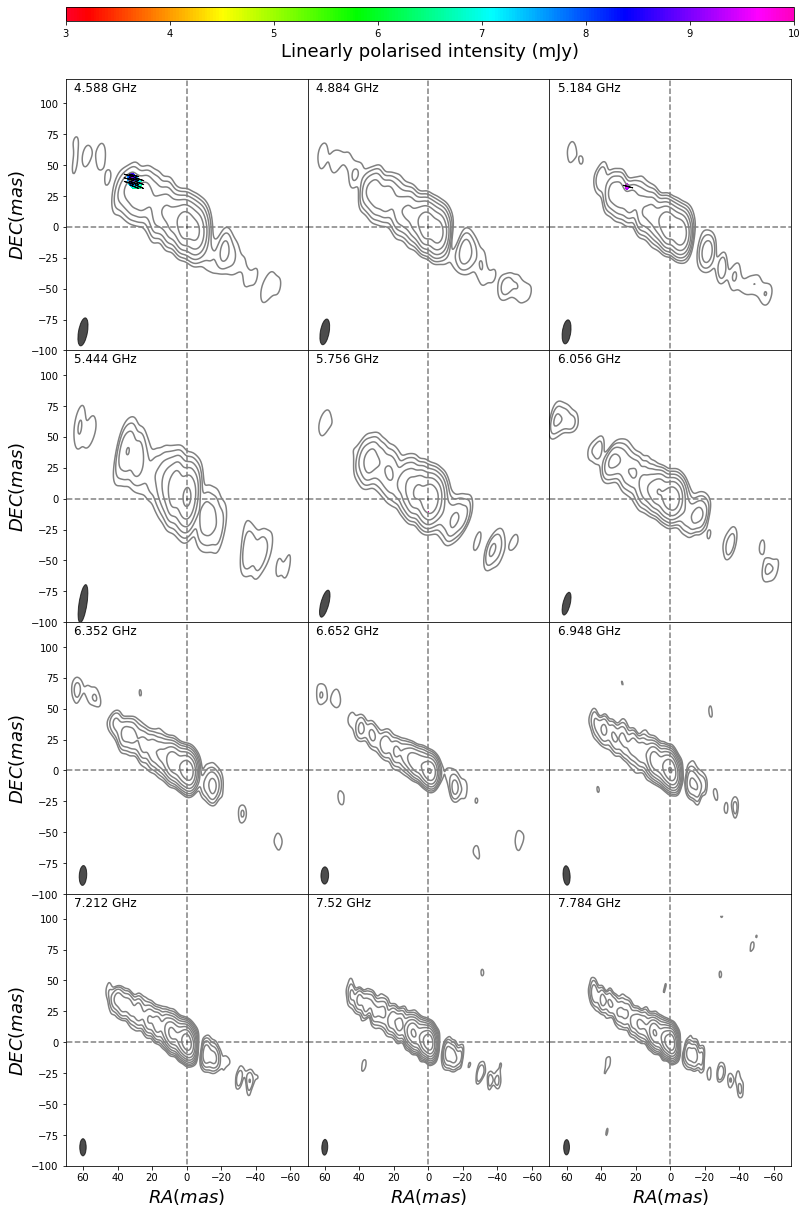

In [9]:
epoch = 12
fig, axes = plt.subplots(nrows = 4, ncols=3, figsize=(13, 20),
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.0})
s = getData(epoch, 0, axes[0][0])
_ = getData(epoch, 1, axes[0][1])
_ = getData(epoch, 2, axes[0][2])
_ = getData(epoch, 3, axes[1][0])
_ = getData(epoch, 4, axes[1][1])
_ = getData(epoch, 5, axes[1][2])
_ = getData(epoch, 6, axes[2][0])
_ = getData(epoch, 7, axes[2][1])
_ = getData(epoch, 8, axes[2][2])
_ = getData(epoch, 9, axes[3][0])
_ = getData(epoch, 10, axes[3][1])
_ = getData(epoch, 11, axes[3][2])

## make ticks dissapear
axes[0][0].set_xticks([])
axes[0][1].set_xticks([])
axes[0][2].set_xticks([])

axes[1][0].set_xticks([])
axes[1][1].set_xticks([])
axes[1][2].set_xticks([])

axes[2][0].set_xticks([])
axes[2][1].set_xticks([])
axes[2][2].set_xticks([])

axes[0][1].set_yticks([])
axes[1][1].set_yticks([])
axes[2][1].set_yticks([])
axes[3][1].set_yticks([])

axes[0][2].set_yticks([])
axes[1][2].set_yticks([])
axes[2][2].set_yticks([])
axes[3][2].set_yticks([])

# axes[0][3].set_yticks([])
# axes[1][3].set_yticks([])
# axes[2][3].set_yticks([])
# axes[3][3].set_yticks([])



font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

axes[0][0].set_ylabel(r'$DEC (mas)$', **font)
axes[1][0].set_ylabel(r'$DEC (mas)$', **font)
axes[2][0].set_ylabel(r'$DEC (mas)$', **font)
axes[3][0].set_ylabel(r'$DEC (mas)$', **font)

axes[3][0].set_xlabel(r'$RA (mas)$', **font)
axes[3][1].set_xlabel(r'$RA (mas)$', **font)
axes[3][2].set_xlabel(r'$RA (mas)$', **font)


ax_custom = fig.add_axes([0.125, 0.92, 0.778, 0.01])
cbar = plt.colorbar(s, cax=ax_custom,orientation='horizontal')
cbar.set_label('Linearly polarised intensity (mJy)', fontsize=18)

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('montageEpoch{}.png'.format(epoch), dpi=300)